In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *


# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_4mm_smear.h5',"MC/hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_1mmbin.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_1mmstep_high_E_slim_smear.h5","hits")


# hits = pd.read_hdf("../data/ATPC_gamma/ATPC_gamma_SF0_779551_24.h5", "hits")

# hits = pd.read_hdf("../../NEXT_nudobe/files/data/mbb_0_1mm_smear.h5", "MC/hits")

hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_smear_225.h5", "MC/hits")


# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_SF0_779552_232.h5", "hits")

display(hits)


,event_id,x,y,z,energy
0,11300,-1442.772095,-482.059631,5283.557129,0.000075
1,11300,-1444.964355,-483.240204,5283.627441,0.001375
2,11300,-1440.086426,-480.735413,5283.657715,0.003825
3,11300,-1434.636597,-478.883301,5283.843750,0.001150
4,11300,-1449.957031,-486.046478,5283.895020,0.002300
...,...,...,...,...,...
27329,11326,-827.042603,-1937.431641,4143.975586,0.000300
27330,11326,-840.641418,-1931.412476,4144.221191,0.001300
27331,11326,-837.630249,-1932.569580,4144.608398,0.000075
27332,11326,-830.652161,-1935.606934,4144.857910,0.006875


,event_id,x,y,z,energy
0,11300,-1907.980103,-617.252808,5702.807129,0.000225
1,11300,-1907.896851,-619.562744,5703.752441,0.001525
2,11300,-1907.683960,-614.300842,5701.821289,0.002100
3,11300,-1907.511475,-606.115845,5699.183594,0.000275
4,11300,-1907.478271,-612.638550,5701.281738,0.000050
...,...,...,...,...,...
874,11300,-1366.735962,-420.227112,5318.644043,0.003225
875,11300,-1366.105591,-422.038544,5316.859375,0.000125
876,11300,-1365.238159,-424.240479,5314.136230,0.001825
877,11300,-1364.658569,-426.703369,5312.162109,0.000050


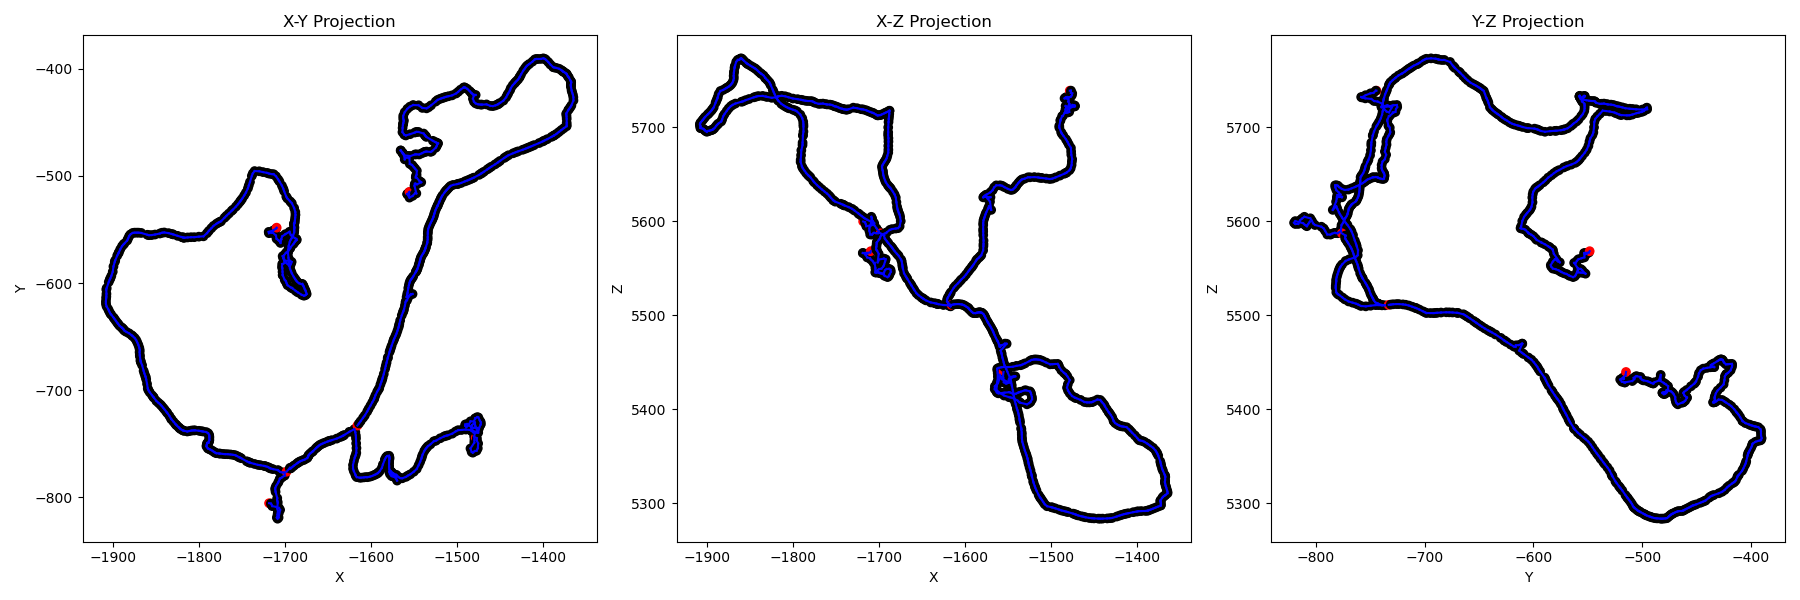

In [2]:
%matplotlib widget

data = hits[hits.event_id ==11300]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
# eid = data.event_id.item()
data = data[['event_id', 'x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}
connections = []

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]


for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break




# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

{'id': 0, 'start': 200, 'end': 221, 'nodes': [200, 203, 205, 207, 219, 240, 244, 237, 227, 222, 228, 238, 230, 231, 225, 229, 226, 223, 224, 214, 212, 213, 217, 233, 239, 242, 246, 250, 266, 273, 269, 256, 245, 236, 232, 208, 202, 201, 196, 194, 193, 191, 189, 187, 184, 182, 180, 178, 174, 171, 170, 168, 166, 165, 162, 160, 158, 156, 154, 152, 149, 148, 147, 145, 143, 135, 131, 126, 127, 129, 130, 133, 134, 137, 138, 142, 141, 140, 139, 132, 125, 123, 122, 121, 119, 117, 116, 114, 112, 110, 108, 106, 104, 103, 102, 100, 99, 98, 97, 94, 93, 92, 90, 89, 88, 86, 84, 83, 81, 80, 78, 77, 76, 74, 72, 71, 69, 68, 67, 66, 65, 64, 63, 61, 60, 59, 58, 57, 55, 56, 54, 52, 51, 49, 48, 46, 44, 41, 38, 37, 35, 33, 32, 30, 28, 25, 24, 22, 19, 17, 14, 12, 10, 8, 6, 1, 0, 2, 4, 5, 3, 7, 9, 11, 13, 15, 16, 18, 20, 21, 23, 26, 27, 29, 31, 34, 36, 39, 40, 42, 43, 45, 47, 50, 53, 62, 70, 73, 75, 79, 82, 85, 87, 91, 95, 96, 101, 105, 107, 109, 111, 113, 115, 118, 120, 124, 128, 136, 144, 146, 150, 151, 153,

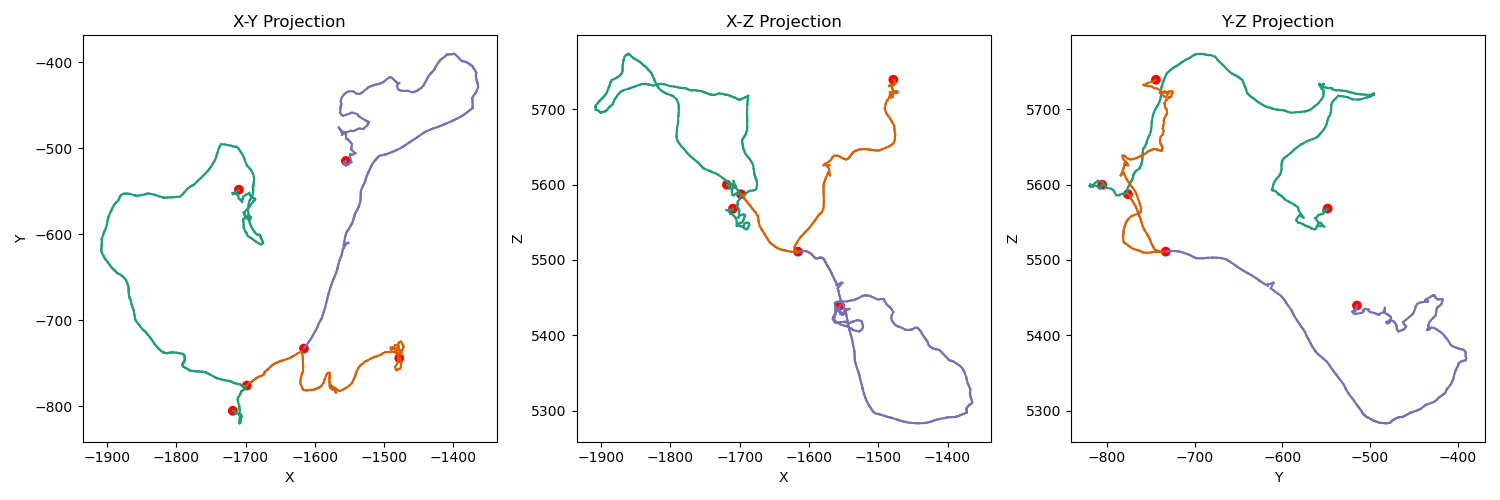

In [3]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [4]:
print(GetMeanNodeDist(Tracks, data))

dist_threshold = 4*GetMeanNodeDist(Tracks, data)

3.182


In [5]:
# Now look to merge tracks that are close by and identify deltas

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)


In [6]:

finished = False  # Initial state

# Tracks2 = Tracks
# Tracks2 = copy.deepcopy(Tracks)
# # Temporarily add the connection to check for cycles
# temp_connections_dict = copy.deepcopy(connected_nodes)
# temp_connections      = copy.deepcopy(connections)
# temp_connection_count = copy.deepcopy(connection_count)

q = 0
while not finished:
    print("Loop: ", q)
    # finished, Tracks2 = ConnectTracks(Tracks2, temp_connections_dict, temp_connections, temp_connection_count)
    finished, Tracks = ConnectTracks(Tracks, connected_nodes, connections, connection_count, dist_matrix, dist_threshold, data)

    q=q+1

print(finished)

print("Total Tracks:", len(Tracks))

for t in Tracks:
    print(t)




Loop:  0
Loop:  1
Loop:  2
True
Total Tracks: 3
{'id': 4, 'start': 269, 'end': 200, 'nodes': [269, 273, 266, 250, 246, 242, 239, 233, 217, 213, 212, 214, 224, 223, 226, 229, 225, 231, 230, 238, 228, 222, 227, 237, 244, 240, 219, 207, 205, 203, 200], 'length': 92.773, 'energy': 0.16864999977406114, 'label': 'track', 'c': 'black'}
{'id': 6, 'start': 399, 'end': 750, 'nodes': [399, 402, 405, 406, 407, 409, 408, 403, 400, 398, 395, 396, 397, 401, 404, 410, 413, 415, 417, 419, 421, 423, 425, 428, 431, 433, 434, 437, 440, 443, 445, 448, 450, 454, 460, 461, 463, 458, 456, 453, 457, 455, 462, 466, 468, 471, 474, 479, 481, 487, 483, 477, 485, 470, 459, 465, 472, 475, 484, 490, 493, 498, 524, 534, 548, 561, 580, 587, 594, 598, 600, 603, 608, 615, 621, 628, 633, 643, 650, 664, 670, 674, 677, 682, 684, 687, 692, 699, 711, 722, 726, 746, 752, 759, 760, 763, 758, 756, 753, 741, 730, 721, 708, 705, 702, 698, 697, 700, 701, 706, 707, 713, 732, 744, 743, 757, 766, 769, 773, 772, 770, 768, 765, 747, 742

In [7]:
# Re-Color the tracks
Tracks = CategorizeTracks(Tracks)


In [8]:
for c in connection_count:
    if (c>2):print(c)

3
3


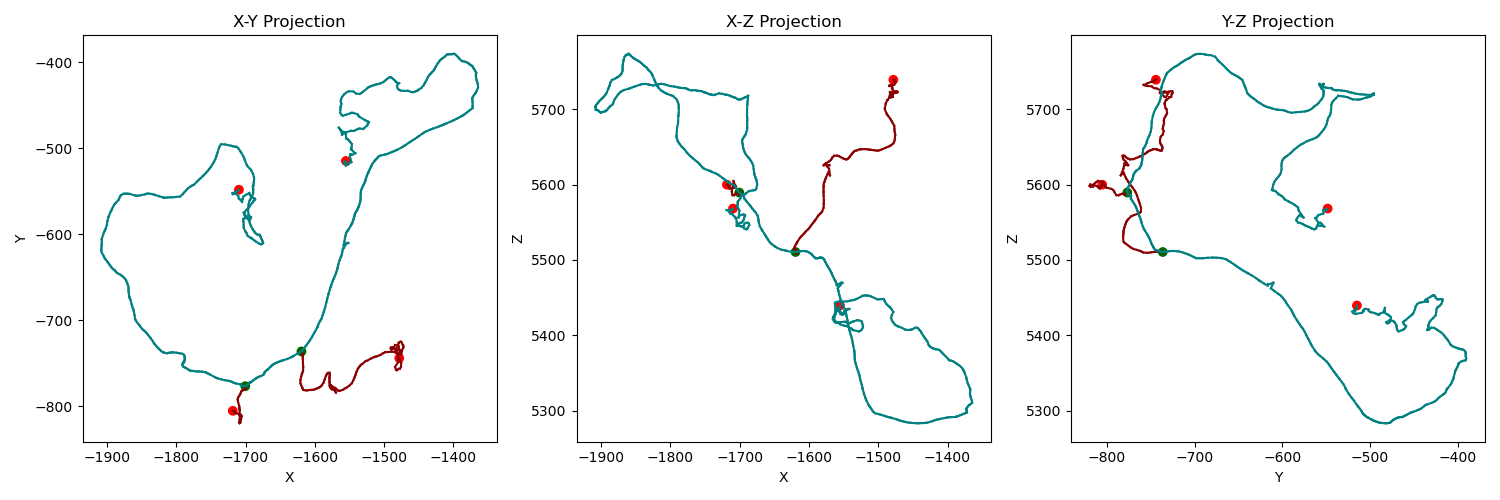

In [9]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [10]:
for i in connected_nodes:
    [print(connected_nodes[i])]

[1, 2]
[0, 6]
[4, 0]
[2, 5]
[7, 5]
[3, 9]
[4, 3]
[1, 8]
[10, 6]
[8, 12]
[11, 7]
[9, 13]
[11, 15]
[14, 10]
[12, 17]
[13, 16]
[15, 18]
[19, 14]
[17, 22]
[20, 16]
[18, 21]
[20, 23]
[19, 24]
[26, 21]
[23, 27]
[25, 22]
[24, 28]
[26, 29]
[25, 30]
[27, 31]
[32, 28]
[30, 33]
[34, 29]
[31, 36]
[35, 32]
[33, 37]
[34, 39]
[35, 38]
[41, 37]
[38, 44]
[40, 36]
[39, 42]
[43, 40]
[42, 45]
[46, 41]
[44, 48]
[47, 43]
[45, 50]
[47, 53]
[49, 46]
[48, 51]
[49, 52]
[50, 62]
[51, 54]
[56, 52]
[54, 55]
[56, 57]
[58, 55]
[57, 59]
[60, 58]
[59, 61]
[60, 63]
[53, 70]
[61, 64]
[65, 63]
[64, 66]
[67, 65]
[66, 68]
[67, 69]
[68, 71]
[73, 62]
[70, 75]
[72, 69]
[71, 74]
[72, 76]
[73, 79]
[77, 74]
[76, 78]
[77, 80]
[75, 82]
[81, 78]
[80, 83]
[81, 84]
[85, 79]
[82, 87]
[83, 86]
[85, 91]
[88, 84]
[86, 89]
[90, 88]
[89, 92]
[95, 87]
[91, 96]
[90, 93]
[94, 92]
[93, 97]
[95, 101]
[94, 98]
[99, 97]
[98, 100]
[99, 102]
[105, 96]
[101, 107]
[103, 100]
[102, 104]
[103, 106]
[105, 109]
[108, 104]
[106, 110]
[107, 111]
[108, 112]

In [11]:
# Get the track with the most nodes, this is taken to be the primary

num_nodes = 0
primary_track_id = -1
primary_nodes = []

for t in Tracks:
    if ( len(t["nodes"]) > num_nodes):
        num_nodes = len(t["nodes"])
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]

print("The primary track is: ", primary_track_id)

# This list makes sure we only have one angle per node
all_visited = []

Primary_Track = data.reindex(primary_nodes)
Primary_Track = GetAnglesDF(Primary_Track, all_visited, 1, primary_track_id)
all_visited = all_visited + primary_nodes

df_angles = pd.DataFrame()
df_angles = pd.concat([df_angles, Primary_Track], ignore_index=True)

for t in Tracks:

    trk_nodes = t["nodes"]
    if t["id"] == primary_track_id:
        continue
    else:
        
        # See if the first/last node has three connections. If it does then flip the track
        con_end = connection_count[t["nodes"][-1]]
        if (con_end == 3):
            trk_nodes = trk_nodes[::-1]
        
        trk = data.reindex(trk_nodes)

        trk = GetAnglesDF(trk, all_visited, 0, t["id"])
        all_visited = all_visited + trk_nodes
        df_angles = pd.concat([df_angles, trk], ignore_index=True)


# Primary_Track.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', 100)
display(df_angles[df_angles.trkID ==5])

print(connected_nodes)



The primary track is:  7


,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle


{0: [1, 2], 1: [0, 6], 2: [4, 0], 4: [2, 5], 3: [7, 5], 7: [3, 9], 5: [4, 3], 6: [1, 8], 8: [10, 6], 10: [8, 12], 9: [11, 7], 11: [9, 13], 13: [11, 15], 12: [14, 10], 14: [12, 17], 15: [13, 16], 16: [15, 18], 17: [19, 14], 19: [17, 22], 18: [20, 16], 20: [18, 21], 21: [20, 23], 22: [19, 24], 23: [26, 21], 26: [23, 27], 24: [25, 22], 25: [24, 28], 27: [26, 29], 28: [25, 30], 29: [27, 31], 30: [32, 28], 32: [30, 33], 31: [34, 29], 34: [31, 36], 33: [35, 32], 35: [33, 37], 36: [34, 39], 37: [35, 38], 38: [41, 37], 41: [38, 44], 39: [40, 36], 40: [39, 42], 42: [43, 40], 43: [42, 45], 44: [46, 41], 46: [44, 48], 45: [47, 43], 47: [45, 50], 50: [47, 53], 48: [49, 46], 49: [48, 51], 51: [49, 52], 53: [50, 62], 52: [51, 54], 54: [56, 52], 56: [54, 55], 55: [56, 57], 57: [58, 55], 58: [57, 59], 59: [60, 58], 60: [59, 61], 61: [60, 63], 62: [53, 70], 63: [61, 64], 64: [65, 63], 65: [64, 66], 66: [67, 65], 67: [66, 68], 68: [67, 69], 69: [68, 71], 70: [73, 62], 73: [70, 75], 71: [72, 69], 72: [71

Text(0, 0.5, 'Scatter Angle [deg]')

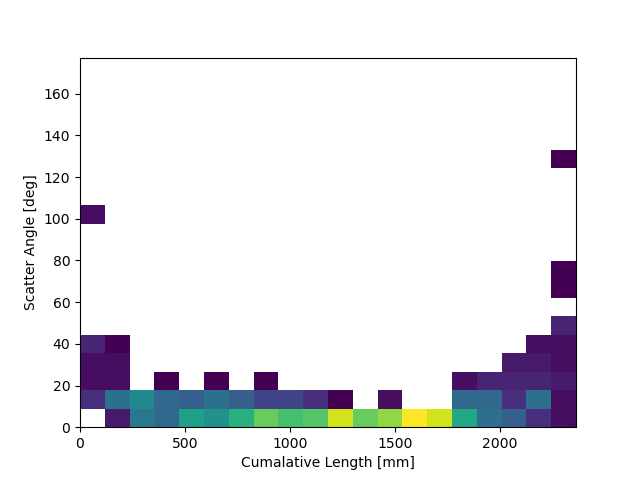

In [12]:
plt.figure()
# plt.scatter(Primary_Track.x, Primary_Track.z)

# plt.scatter(Primary_Track.index, Primary_Track.angle)

# plt.hist(Primary_Track.angle)
# plt.semilogy()
plt.hist2d(Primary_Track.cumulative_distance, Primary_Track.angle, bins = 20,cmin=3);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle)

plt.xlabel("Cumalative Length [mm]")
plt.ylabel("Scatter Angle [deg]")

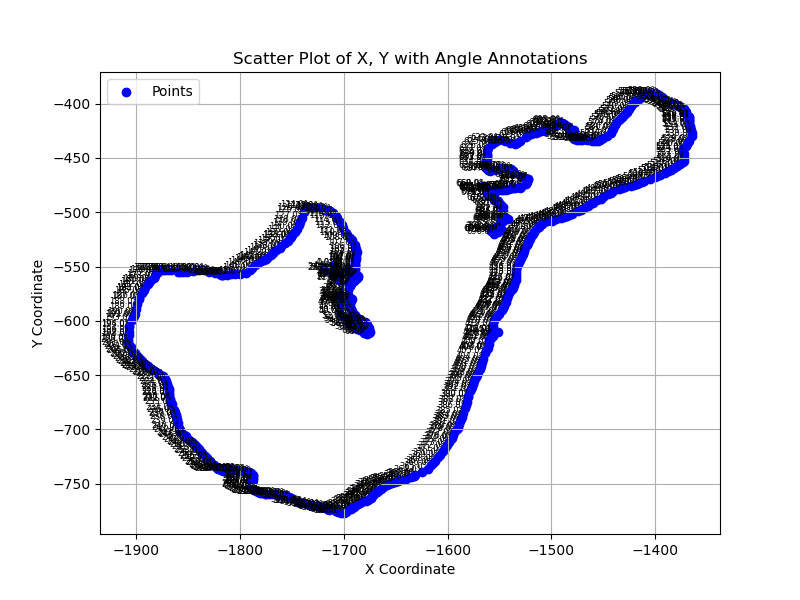

In [13]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Primary_Track['x'], Primary_Track['y'], color='blue', label='Points')

# Annotate each point with the corresponding angle
for i in range(len(Primary_Track)):
    x = Primary_Track.iloc[i]['x']
    y = Primary_Track.iloc[i]['y']
    # angle = Primary_Track.loc[i, 'angle']
    angle = i
    
    # Only annotate if angle is not NaN
    if not np.isnan(angle):
        plt.text(x, y, f'{angle:.1f}°', fontsize=6, ha='right')

# Additional plot settings
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of X, Y with Angle Annotations')
plt.legend()
plt.grid(True)

# Show plot
plt.show()